# WhatsApp network traffic analyzing project
## Part A - data cleaning

### Introduction
Although the WhatsApp software is encrypted and there is no access to the information content, we wanted to investigate whether it is possible to draw conclusions from the network traffic analysis.

We based on the idea of the academic paper ["Practical Traffic Analysis Attacks on Secure Messaging Applications"](https://www.ndss-symposium.org/wp-content/uploads/2020/02/24347-paper.pdf)

For the purpose of analyzing the traffic of WhatsApp Web, we made recordings using Wireshark of several WhatsApp groups conversations, in each group, besides the text messages, we attached specific kind of messages that we transferred between us:
- messages
- photos
- audio
- videos
- documents

We also made additional recordings of:

- Conversation (including photos, recordings, etc.) with noise - with Spotify running in the background, entering other websites, etc.

- conversation (including photos, recordings, etc.) and at the same time when one of us (simulating the attacked) makes regular use of other groups/conversations that the attacker is not a part of

We saved the recordings as a csv files in "resources" directory

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from time import sleep
import requests
import os

### Auxiliary functions

### Addition columns of time and packet lengths differences, and reformatting columns type

In [2]:
# Time delays between 2 consecutive packets
def add_delays(df: pd.DataFrame):
    df["Time_delay"] = (df["Time"].diff().fillna(0)).round(6)

# Packets length diffs 2 consecutive messages
def add_lengths(df: pd.DataFrame):
    df["Length_diff"] = abs(df["Length"].diff()).fillna(0)


def reformat_columns(df: pd.DataFrame):
    df["No."] = df["No."].astype(float)
    df["Time"] = df["Time"].astype(float)
    df["Length"] = df["Length"].astype(float)

### Redirection to the raw csv files folder

In [3]:
def getRawCsv():
    # Get the current directory where your notebook is located
    current_dir = os.getcwd()

    # Construct the path to the "resources" directory
    resources_dir = os.path.join(current_dir, '..', 'resources')

    # Construct the path to the "RAW" directory within "resources"
    raw_csv_dir = os.path.join(resources_dir, r'RAW/CSV/')
    return raw_csv_dir

### Loading the required data frame

In [4]:
file_name = None

def load_csv(number):
    work_path = getRawCsv()
    if number == '1':
        file_name = "whatsappMessagesCSV"
        path = work_path + file_name + ".csv"
        print("---------Mixed Group (Mostly Messages)----------")
    elif number == '2':
        file_name = "whatsappImagesCSV"
        path = work_path + file_name + ".csv"
        print("---------Images----------")
    elif number == '3':
        file_name = "whatsappAudioCSV"
        path = work_path + file_name + ".csv"
        print("---------Audio----------")
    elif number == '4':
        file_name = "whatsappVideosCSV"
        path = work_path + file_name + ".csv"
        print("---------Videos----------")
    elif number == '5':
        file_name = "whatsappFilesCSV"
        path = work_path + file_name + ".csv"
        print("---------Files----------")
    elif number == '6':
        file_name = "WhatsappNoisedGroupCSV"
        path = work_path + file_name + ".csv"
        print("---------Group With Noise----------")
    elif number == '7':
        file_name = "whatsappAttackedRegularUseCSV"
        path = work_path + file_name + ".csv"
        print("---------Attacked User Active in multiple groups (usual activity)----------")
    elif number == '8':
        file_name = "whatsappAttackerRegularUseCSV"
        path = work_path + file_name + ".csv"
        print("--------- Attacker when Attacked User Active in multiple groups (usual activity)----------")
    
    df = pd.read_csv(path, sep=',', header=0,
                     usecols=["No.", "Time", "Source", "Destination", "Protocol", "Length", "Info"])
    reformat_columns(df)
    add_delays(df)
    add_lengths(df)
    print(df.head())
    return df, file_name

### Visualizations

In [5]:
# Packets size as a function of time
def plot_activity_trends(df):
    # Plot the message count over time using a line chart
    plt.figure(figsize=(15, 4))
    plt.plot(df["Time"], df["Length"], marker='o', linestyle='-')
    plt.xlabel("Time")
    plt.ylabel("Length")
    plt.title("Message Count and Activity Trends")
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [6]:
#bar plot of length packetlength changes in time
def bar_plot(df):
    plt.figure(figsize=(9, 4))
    plt.bar(df["Time"], df["Length"])
    plt.xlabel("Time")
    plt.ylabel("Length")
    plt.title("Bar Chart of Length vs Time")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

In [7]:
def plot_length_range_counts(length_range_counts):
    range_names = list(length_range_counts.keys())
    counts = list(length_range_counts.values())
    
    plt.figure(figsize=(5, 4))
    plt.bar(range_names, counts)
    plt.xlabel("Length Range")
    plt.ylabel("Count")
    plt.title("Count of Cells in Each Length Range")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

In [8]:
# plot of packet length with the frequency of this packet length
def plot_length_histogram(df: pd.DataFrame):
    plt.figure(figsize=(10, 6))
    plt.hist(df["Length"], bins=df["Length"].nunique(), edgecolor="black")
    plt.xlabel("Length")
    plt.ylabel("Frequency")
    plt.title("Length Histogram")
    plt.show()

### Main run function 

Please select which Whatsapp Group you want to clean:
1 - Mixed messages (a bit from everything)
2 - Mostly Images
3 - Mostly Audio
4 - Mostly videos
5 - Mostly Files
6 - Noisy recording
7 - Attacked user active in several groups
8 - Attacker when Attacked user active in several groups
9 - Exit
7
---------Attacked User Active in multiple groups (usual activity)----------
   No.      Time          Source     Destination Protocol  Length  \
0  1.0  0.000000       10.0.2.15  157.240.196.60  TLSv1.2   122.0   
1  2.0  0.001124  157.240.196.60       10.0.2.15      TCP    60.0   
2  3.0  0.637106       10.0.2.15  157.240.196.60  TLSv1.2   122.0   
3  4.0  0.637797  157.240.196.60       10.0.2.15      TCP    60.0   
4  5.0  0.890219  157.240.196.60       10.0.2.15  TLSv1.2   185.0   

                                                Info  Time_delay  Length_diff  
0                                   Application Data    0.000000          0.0  
1   443  >  42468 [ACK] Seq=1 Ack=69 Win=65535 Len=

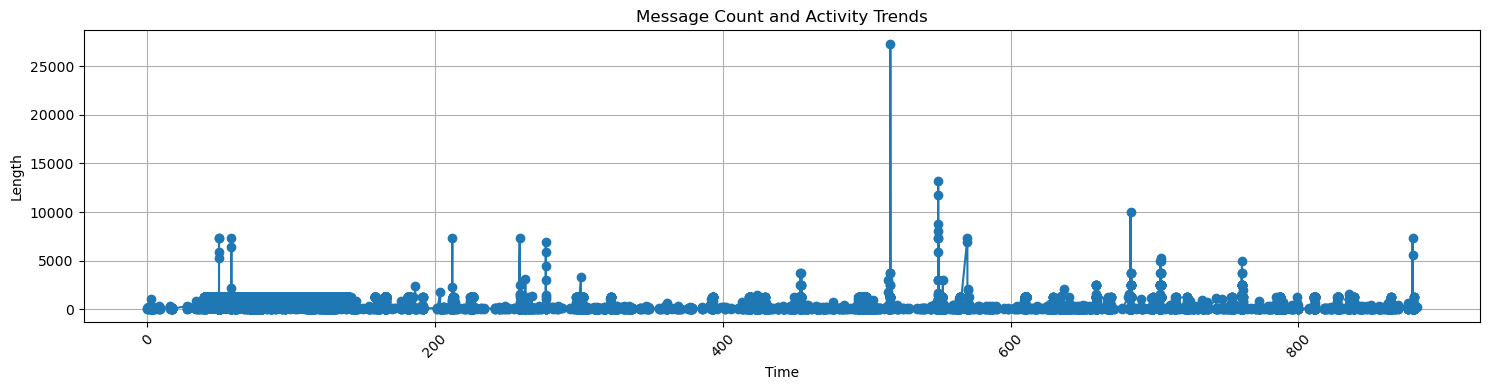

In [9]:
isvalid = True
while isvalid:
    answer = input("Please select which Whatsapp Group you want to clean:\n"
                           "1 - Mixed messages (a bit from everything)\n"
                           "2 - Mostly Images\n"
                           "3 - Mostly Audio\n"
                           "4 - Mostly videos\n"
                           "5 - Mostly Files\n"
                           "6 - Noisy recording\n"
                           "7 - Attacked user active in several groups\n"
                           "8 - Attacker when Attacked user active in several groups\n"
                           "9 - Exit\n")
    options = ['1','2','3','4','5','6','7','8','9']
    if answer not in options:
        print("Invalid value. Please enter a valid number\n")
    elif answer == '9':
        isvalid = False
        print("Goodbye")
    else:
        isvalid = False
        df, name = load_csv(answer)
        plot_activity_trends(df)

In [10]:
df

,No.,Time,Source,Destination,Protocol,Length,Info,Time_delay,Length_diff
0,1.0,0.000000,10.0.2.15,157.240.196.60,TLSv1.2,122.0,Application Data,0.000000,0.0
1,2.0,0.001124,157.240.196.60,10.0.2.15,TCP,60.0,443 > 42468 [ACK] Seq=1 Ack=69 Win=65535 Len=0,0.001124,62.0
2,3.0,0.637106,10.0.2.15,157.240.196.60,TLSv1.2,122.0,Application Data,0.635982,62.0
3,4.0,0.637797,157.240.196.60,10.0.2.15,TCP,60.0,443 > 42468 [ACK] Seq=1 Ack=137 Win=65535 Len=0,0.000690,62.0
4,5.0,0.890219,157.240.196.60,10.0.2.15,TLSv1.2,185.0,"Application Data, Application Data",0.252422,125.0
...,...,...,...,...,...,...,...,...,...
18495,18496.0,880.383432,10.0.2.15,157.240.196.60,TCP,54.0,37358 > 443 [ACK] Seq=3730 Ack=1228 Win=6402...,0.000057,203.0
18496,18497.0,880.424875,157.240.196.60,10.0.2.15,TLSv1.3,299.0,"Application Data, Application Data",0.041443,245.0
18497,18498.0,880.468863,10.0.2.15,157.240.196.60,TCP,54.0,37382 > 443 [ACK] Seq=582 Ack=2651 Win=63240...,0.043988,245.0
18498,18499.0,881.018402,10.0.2.15,239.255.255.250,SSDP,215.0,M-SEARCH * HTTP/1.1,0.549538,161.0


## Cleaning and Filtering process
Initially, we tried to filter the data by its protocol but it doesnt gave good outcomes. So, we filtered irrelevant protocols like DNS and NTP, focusing on WhatsApp-related ones.

In [11]:
protocol_counts = df['Protocol'].value_counts()
print(protocol_counts)

QUIC       13921
TCP         2550
TLSv1.2     1439
TLSv1.3      369
DNS          158
SSDP          32
MDNS          20
HTTP           6
NBNS           3
NTP            2
Name: Protocol, dtype: int64



protocols that appeared in some recordings, but are not containing messages content:
- Elasticsearch: Not a communication protocol but rather a search engine. Elasticsearch operates over HTTP, so the packets might be associated with search queries or indexing operations.
- DNS: Domain Name System, used for domain name resolution. its packets doesn't contain message content
- SSDP: Simple Service Discovery Protocol, primarily used with UPnP (Universal Plug and Play). It's not related to WhatsApp messages.
- HTTP: The foundation of any data exchange on the Web. WhatsApp might use HTTP for certain services, but not likely for message transmission as it would be less secure.
- NTP: Network Time Protocol. It's used to synchronize the clocks of computer systems over packet-switched, variable-latency data networks. This would not contain WhatsApp message content.
- MDNS: Multicast DNS. Used for resolving hostnames to IP addresses within small networks that do not include a local name server. Not related to WhatsApp message content.
- ICMPv6: It's used for diagnostic purposes, error reporting, and other operations related to the management of IP networks.wouldn't contain the content of WhatsApp messages.
- NBNS: protocol used on IP networks like the Internet to provide name resolution for NetBIOS over TCP/IP. Thus, doesn't contains data packets.

Thus, we will filter out the rows wherethe protocol is one of the listed above'''

In [12]:
# List of protocols to exclude
protocols_to_exclude = ['Elasticsearch', 'DNS', 'SSDP', 'HTTP', 'NTP', 'MDNS', 'ICMPv6', 'NBNS']

# Filter rows
df = df[~df['Protocol'].isin(protocols_to_exclude)]

In [13]:
protocol_counts = df['Protocol'].value_counts()
print(protocol_counts)

QUIC       13921
TCP         2550
TLSv1.2     1439
TLSv1.3      369
Name: Protocol, dtype: int64


### Detect the major IP addresses
We assumed that since WhatsApp belongs to Facebook - we observed that most of the IP addresses that appear in the traffic will be those of the target device and of Facebook's servers or of Internet provider.

With this information it will be possible to filter out noise and in addition to ignore stations on the way that do not add any information to us for analysis

In [14]:
ip_counts = df['Source'].value_counts()
print(ip_counts)

10.0.2.15         10230
192.117.112.96     4445
157.240.196.60     3423
172.217.22.78       114
172.217.22.42        35
142.250.27.188       20
185.125.190.18        4
91.189.91.49          4
185.125.190.48        4
Name: Source, dtype: int64


In [15]:
# Create a true copy of df
temp_df = df.copy()

# Extract the first number from the "Source" column
temp_df["FirstNumber"] = temp_df["Source"].str.split('.').str[0]

# Group by both FirstNumber, average packet length, and most used protocol
result_df = temp_df.groupby(["FirstNumber"]).agg(
    Count=('Source', 'size'),
    MedianPacketLength=('Length', 'median'),
    MostUsedProtocol=('Protocol', lambda x: x.mode()[0] if not x.mode().empty else None)  # Use mode to find the most frequent protocol
).reset_index()

result = result_df.groupby("FirstNumber").agg(
    TotalCount=('Count', 'sum'),
    OverallMedianPacketLength=('MedianPacketLength', 'median'),
    OverallMostUsedProtocol=('MostUsedProtocol', lambda x: x.mode()[0] if not x.mode().empty else None)
).reset_index()

result = result.sort_values(by='TotalCount', ascending=False).reset_index(drop=True)

print(result)

  FirstNumber  TotalCount  OverallMedianPacketLength OverallMostUsedProtocol
0          10       10230                     1292.0                    QUIC
1         192        4445                       90.0                    QUIC
2         157        3423                      303.0                    QUIC
3         172         149                      198.0                    QUIC
4         142          20                       60.0                     TCP
5         185           8                       60.0                     TCP
6          91           4                       60.0                     TCP


The next step is that we checked message-sending IPs and removed those not linked to WhatsApp.

Non-Facebook servers not in Israel were filtered out.

Most WhatsApp data goes via Facebook's servers, except for larger transmissions using local servers.

### Extract releveant IP adresses
We used IP filtering by packet count and median size.

    IPs with >1000 packets were significant;
    a median > 500 indicated relevant data.
    Large servers had a median ~1200,
    so we set 500 as the threshold.

In [16]:
my_country="IL"

def rows_of_probably_noisy_packets(df):
    df_copy = df.copy()  # Explicitly make a copy of the dataframe

    # Extract the first number from the "Source" column
    df_copy["FirstNumber"] = df_copy["Source"].str.split('.').str[0]

    median_lengths = df_copy.groupby('FirstNumber')['Length'].median()
    
    lots_of_packets = df_copy.groupby('FirstNumber')['Length'].count()

    # Filter the 'FirstNumber' values where the median is greater than 500
    desired_nums = list(set(median_lengths[median_lengths > 500].index.tolist()) | set(lots_of_packets[lots_of_packets > 1000].index.tolist()))
    
    wanted_ips = set()
    unwanted_ips = set()
    
    for index, row in df_copy.iterrows():
        if row['FirstNumber'] in desired_nums and not (row['Source'] in wanted_ips or row['Source'] in unwanted_ips):
            url = f"https://freeipapi.com/api/json/{row['Source']}"
            response = requests.get(url)
            data = response.json()
            country = data['countryCode']
            if country == my_country:
                wanted_ips.add(row['Source'])
            else:
                unwanted_ips.add(row['Source'])
            sleep(0.02)

    rows_of_interest_src = df_copy[df_copy['Source'].isin(wanted_ips) |
                                   df_copy['Source'].str.startswith(('157', '10'))].index.tolist()
    
    rows_of_interest_dst = df_copy[df_copy['Destination'].isin(wanted_ips) |
                                   df_copy['Destination'].str.startswith(('157', '10'))].index.tolist()
    
    row_numbers = list(set(rows_of_interest_dst) & set(rows_of_interest_src))

    return row_numbers

In [17]:
df = df.loc[rows_of_probably_noisy_packets(df)]

### Packet size anomalies filter 
We handled packet size anomalies - If top 3 packets were >3x larger than the next, likely recording error, we removed them.

In [18]:
sorted_lengths = df['Length'].sort_values(ascending=False).reset_index(drop=True)

# Define threshold number of packets
num_outliers = min(int(len(df) * 0.001), len(df[df['Length'] > 10000]))

# Check the size of the packet just below the threshold
packet_below_threshold = sorted_lengths.iloc[num_outliers]

# If the largest packet is more than 3 times the packet_below_threshold, filter out the outliers
if sorted_lengths.iloc[0] > 3 * packet_below_threshold:
    # Get all the lengths considered outliers
    outlier_lengths = sorted_lengths.head(num_outliers).to_list()
    df = df[~df['Length'].isin(outlier_lengths)]

In [19]:
df

,No.,Time,Source,Destination,Protocol,Length,Info,Time_delay,Length_diff
0,1.0,0.000000,10.0.2.15,157.240.196.60,TLSv1.2,122.0,Application Data,0.000000,0.0
1,2.0,0.001124,157.240.196.60,10.0.2.15,TCP,60.0,443 > 42468 [ACK] Seq=1 Ack=69 Win=65535 Len=0,0.001124,62.0
2,3.0,0.637106,10.0.2.15,157.240.196.60,TLSv1.2,122.0,Application Data,0.635982,62.0
3,4.0,0.637797,157.240.196.60,10.0.2.15,TCP,60.0,443 > 42468 [ACK] Seq=1 Ack=137 Win=65535 Len=0,0.000690,62.0
4,5.0,0.890219,157.240.196.60,10.0.2.15,TLSv1.2,185.0,"Application Data, Application Data",0.252422,125.0
...,...,...,...,...,...,...,...,...,...
18493,18494.0,880.339838,157.240.196.60,10.0.2.15,TCP,60.0,443 > 37382 [ACK] Seq=2406 Ack=582 Win=65535...,0.000489,58.0
18494,18495.0,880.383375,157.240.196.60,10.0.2.15,TLSv1.3,257.0,Application Data,0.043537,197.0
18495,18496.0,880.383432,10.0.2.15,157.240.196.60,TCP,54.0,37358 > 443 [ACK] Seq=3730 Ack=1228 Win=6402...,0.000057,203.0
18496,18497.0,880.424875,157.240.196.60,10.0.2.15,TLSv1.3,299.0,"Application Data, Application Data",0.041443,245.0


### No data packets filter 
Filtered 'info' description content: 'Len=0' packets (no data) were excluded.

In [20]:
df = df[~(df['Info'].str.contains('Len=0', case=False, na=False))]

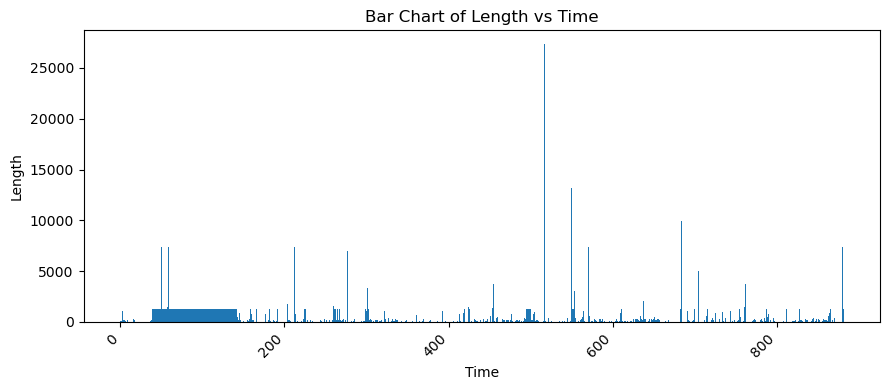

In [21]:
bar_plot(df)

### Remove irrelevant rows
The assumption is that text messages do not take up a large volume of traffic, while sending a large file significantly increases the length of the packets, so when sending a photo/video, etc., we expect to see a significant jump.

We also noticed that WhatsApp performs validation and encryption of the information during the entire conversation, so that there are packets without information in the content but only with headers, etc.

Therefore, given that has been sent a large file - we would like to remove the small packets that were sent in the middle of sending the large file, so that after a plot is made we will see the packets of the file contiguous without spaces

In [22]:
grouped_df = df.groupby('Info').size().reset_index(name='Count')
sorted_df = grouped_df.sort_values(by='Count', ascending=False).reset_index(drop=True)

set(sorted_df['Info'].tolist())

{'0-RTT, DCID=0369c3131cf22345',
 '0-RTT, DCID=080b4423305de016',
 '0-RTT, DCID=102a515b00af7436',
 '0-RTT, DCID=10ef920f202aef06',
 '0-RTT, DCID=2a726883fb6ff750',
 '0-RTT, DCID=37962e7d78337400',
 '0-RTT, DCID=4813f1e464a29696',
 '0-RTT, DCID=7bc31b6c140a7c4a',
 '0-RTT, DCID=830f2b04ed3fca91',
 '0-RTT, DCID=88d778c7b7152504',
 '0-RTT, DCID=a245e41611d47139',
 '0-RTT, DCID=a8b7433a8df427eb',
 '0-RTT, DCID=a9d624cfc9d3adc6',
 '0-RTT, DCID=ad9bd3d4e2065181',
 '0-RTT, DCID=bbf410fbce5d16c2',
 '0-RTT, DCID=c3a3c536a97cf9a6',
 '0-RTT, DCID=ce09cb53fbedb660',
 '0-RTT, DCID=da6da6cb8c39e0ac',
 '0-RTT, DCID=dcbd6e66d99982b7',
 '0-RTT, DCID=e004d4e18574f435',
 '0-RTT, DCID=eada116dfcd40e64',
 '42468  >  443 [PSH, ACK] Seq=11298 Ack=5279 Win=65535 Len=7300 [TCP segment of a reassembled PDU]',
 '42468  >  443 [PSH, ACK] Seq=120653 Ack=135818 Win=65535 Len=7300 [TCP segment of a reassembled PDU]',
 '42468  >  443 [PSH, ACK] Seq=30902 Ack=19666 Win=65535 Len=7300 [TCP segment of a reassembled PDU]

In [23]:
def remove_middle_row(df: pd.DataFrame, threshold: int = 500, lendth_diff: int = 20):
    # Reset the index to ensure a continuous integer index
    df = df.reset_index(drop=True)
    
    rows_to_remove = []

    for i in range(1, len(df) - 1):
        # Using .iloc for positional indexing
        length_diff = abs(df.iloc[i - 1]["Length"] - df.iloc[i + 1]["Length"])
        
        first_condition = (length_diff <= lendth_diff) and \
                          (df.iloc[i - 1]["Length"] > threshold) and \
                          (df.iloc[i + 1]["Length"] > threshold)
        
        second_condition = (df.iloc[i - 1]["Length"] > threshold) and \
                           (df.iloc[i + 1]["Length"] > threshold) and \
                           (df.iloc[i]["Length"] < threshold)
        
        if (first_condition or second_condition):
            rows_to_remove.append(i)

    cleaned_df = df.drop(rows_to_remove)
    cleaned_df.reset_index(drop=True, inplace=True)
    
    return cleaned_df

### lacking relevant data
Certain 'info' types like 'Initial' or 'Client Hello', lacking relevant data, were removed.

In [24]:
df = df[~df['Info'].str.contains('Initial', case=False, na=False)]
df = df[~(df['Info'].str.contains('Change Cipher Spec', case=False, na=False) & (df['Length'] <= 250))]
df = df[~(df['Info'].str.lower() == 'client hello')]
df = df[~(df['Info'].str.contains('Server Hello', case=False, na=False) & (df['Length'] <= 250))]
cleaned_df = remove_middle_row(df)

In [25]:
df.head(20)

,No.,Time,Source,Destination,Protocol,Length,Info,Time_delay,Length_diff
0,1.0,0.000000,10.0.2.15,157.240.196.60,TLSv1.2,122.0,Application Data,0.000000,0.0
2,3.0,0.637106,10.0.2.15,157.240.196.60,TLSv1.2,122.0,Application Data,0.635982,62.0
4,5.0,0.890219,157.240.196.60,10.0.2.15,TLSv1.2,185.0,"Application Data, Application Data",0.252422,125.0
6,7.0,1.203558,10.0.2.15,157.240.196.60,TLSv1.2,123.0,Application Data,0.272380,69.0
8,9.0,1.723489,10.0.2.15,157.240.196.60,TLSv1.2,124.0,Application Data,0.519269,64.0
10,11.0,2.868427,157.240.196.60,10.0.2.15,TCP,1078.0,"443 > 42468 [PSH, ACK] Seq=132 Ack=276 Win=6...",1.144312,1018.0
12,13.0,2.868428,157.240.196.60,10.0.2.15,TLSv1.2,292.0,Application Data,-0.000034,238.0
14,15.0,2.875127,10.0.2.15,157.240.196.60,TLSv1.2,270.0,Application Data,0.006586,216.0
16,17.0,2.991698,157.240.196.60,10.0.2.15,TLSv1.2,125.0,Application Data,0.115864,65.0
18,19.0,3.263688,157.240.196.60,10.0.2.15,TLSv1.2,165.0,Application Data,0.227548,111.0


Note: We couldn't find unique characteristics for each group.

### Save the cleaned CSV files to resources->CLEAN

In [26]:
def cdCleanCsv():
    # Get the current directory where your notebook is located
    current_dir = os.getcwd()

    # Construct the path to the "resources" directory
    resources_dir = os.path.join(current_dir, '..', 'resources')

    # Construct the path to the "CLEAN" directory within "resources"
    CLEAN_dir = os.path.join(resources_dir, 'CLEAN/')
    return CLEAN_dir

In [27]:
work_path = cdCleanCsv()
df.drop(columns=["Time_delay","Length_diff"], inplace=True)
df.to_csv(work_path + name + 'Clean.csv', index=False)